# Price Prediction - Stage C

## Set Up Notebbok

In [ ]:
%pip install pandas matplotlib seaborn sklearn torch
%pip install "numpy<2" 

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load the dataset
file_path = "./data/booking/processed_booking.csv"
df = pd.read_csv(file_path)
df = df.dropna(subset=['review_score'])

## Data Collection and Processing

We prepare features for modeling, including:
- remove missing values in critical features
- Normalization
- One-hot encoding
- Creating new features

**Categorical Features**
- Converting review scores to integer type
- Converting boolean features (is_apartment, breakfast_included) to binary (0/1)
- Handling missing location scores by filling with mean review scores

**Temporal Features**
- Converting snapshot dates to datetime format
- Calculating check-in dates based on time_to_travel
- Extracting day of month for check-in dates


In [ ]:
df['review_score'] = df['review_score'].astype(int)
df['location_score'] = (df['location_score']).fillna(df['location_score'].mean()).astype(int)
df['is_apartment'] = (df['is_apartment']).fillna(False).astype(int)
df['breakfast_included'] = (df['breakfast_included']).fillna(False).astype(int)

In [ ]:
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')  # Correct format
df['checkin_date'] = df['snapshot_date'] + pd.to_timedelta(df['time_to_travel'], unit='D')  # Add days
df['checkin_day'] = df['checkin_date'].dt.day  # Extract day of the month

In [ ]:
df['is_weekend'] = df['checkin_date'].dt.weekday.apply(lambda x: 1 if x in [1,6,7] else 0) 
df['days_to_end_of_month'] = df['checkin_day'].apply(lambda x: 30 - x)  # Days left to the end of the month
display(df.head())

,Unnamed: 0,name,original_price,discounted_price,discount,review_score,review_title,number_of_reviews,star_rating,is_apartment,...,neighborhood_SoHo,neighborhood_Tribeca,neighborhood_Union Square,neighborhood_Upper East Side,neighborhood_Upper West Side,neighborhood_Washington Heights,checkin_date,checkin_day,is_weekend,days_to_end_of_month
0,0,Iroquois New York Times Square,292,218,0,8,Very good,2625.0,5.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27
1,1,Four Points by Sheraton New York Downtown,130,111,0,7,Good,1987.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27
2,2,"The Mayfair Hotel Times Square, Ascend Hotel C...",141,141,0,8,Fabulous,1895.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27
3,3,The Washington by LuxUrban,160,160,0,7,Good,9442.0,4.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27
4,4,Hampton Inn by Hilton New York Times Square,152,152,0,7,Good,2432.0,3.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2025-02-03,3,0,27


In [ ]:
df['room_type_hash'] = df['room_type'].map(lambda x: hash(x) % 1000)
df['name_hash'] = df['name'].map(lambda x: hash(x) % 1000)

In [ ]:
# Define Features and Target
X = df[['time_to_travel', 'length_of_stay','review_score', 'location_score','is_apartment','breakfast_included', 'days_to_end_of_month', 'is_weekend','room_type_hash','name_hash']]  # Features
y = df['discounted_price_per_night']  # Target Variable

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 🤖 Model Training & Evaluation

We train and evaluate multiple regression models:
- **Linear Regression**
- **Decision Tree Regressor**
- **Gaussian Process Regressor**
- **Neural Networks (Deep Learning)**

We'll assess them using RMSE, MAE, and R².

### Regression Algorithms

In [ ]:
# Train Multiple Regression Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree depth 5': DecisionTreeRegressor(max_depth=5),
    'Decision Tree depth 10': DecisionTreeRegressor(max_depth=10),
    #'Gaussian Process (RBF)': GaussianProcessRegressor(kernel=RBF(1.0)),
    #'Gaussian Process (Matern)': GaussianProcessRegressor(kernel=Matern(length_scale=1.0, nu=1.5)),
    'Random Forest depth 5': RandomForestRegressor(n_estimators=100, max_depth=5),
    'Random Forest depth 10': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting learning_rate 0.1': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'Gradient Boosting learning_rate 0.05': GradientBoostingRegressor(n_estimators=100, learning_rate=0.05),
    'SVR (kernel=rbf)': SVR(kernel='rbf'),
    'SVR (kernel=linear)': SVR(kernel='linear')
}

In [ ]:
#Train and Evaluate Models
results = {}
for name, model_copy in models.items():
     print(f'current model: {name}')
     model_copy.fit(X_train_scaled, y_train)
     print(f'done fit: {name}')
     y_pred = model_copy.predict(X_test_scaled)
     results[name] = {
          'R2': r2_score(y_test, y_pred),
          'MAE': mean_absolute_error(y_test, y_pred),
          'MSE': mean_squared_error(y_test, y_pred),
          'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
     }
     print(f'logged: {name}')

current model: Linear Regression
done fit: Linear Regression
logged: Linear Regression
current model: Decision Tree depth 5
done fit: Decision Tree depth 5
logged: Decision Tree depth 5
current model: Decision Tree depth 10
done fit: Decision Tree depth 10
logged: Decision Tree depth 10
current model: Random Forest depth 5
done fit: Random Forest depth 5
logged: Random Forest depth 5
current model: Random Forest depth 10
done fit: Random Forest depth 10
logged: Random Forest depth 10
current model: Gradient Boosting learning_rate 0.1
done fit: Gradient Boosting learning_rate 0.1
logged: Gradient Boosting learning_rate 0.1
current model: Gradient Boosting learning_rate 0.05
done fit: Gradient Boosting learning_rate 0.05
logged: Gradient Boosting learning_rate 0.05
current model: SVR (kernel=rbf)
done fit: SVR (kernel=rbf)
logged: SVR (kernel=rbf)
current model: SVR (kernel=linear)
done fit: SVR (kernel=linear)
logged: SVR (kernel=linear)


In [ ]:
# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                                            R2        MAE          MSE  \
Linear Regression                     0.192615  52.198085  4331.799753   
Decision Tree depth 5                 0.334190  46.214981  3572.217755   
Decision Tree depth 10                0.581237  34.886225  2246.754908   
Random Forest depth 5                 0.356756  45.384608  3451.147434   
Random Forest depth 10                0.661637  31.556103  1815.391893   
Gradient Boosting learning_rate 0.1   0.577997  36.328236  2264.140273   
Gradient Boosting learning_rate 0.05  0.450414  41.967239  2948.647239   
SVR (kernel=rbf)                      0.239086  48.834756  4082.470240   
SVR (kernel=linear)                   0.168636  51.176819  4460.451767   

                                           RMSE  
Linear Regression                     65.816409  
Decision Tree depth 5                 59.768033  
Decision Tree depth 10                47.399946  
Random Forest depth 5                 58.746467  
Random Fo

In [ ]:
# Plot Residuals for Best Model (Based on R² Score)
best_model_name = results_df['R2'].idxmax()

print(f'BEST MODEL IS: {best_model_name}')
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

BEST MODEL IS: Random Forest depth 10


### Neural Networks

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Neural Network Model 1
class NeuralNet1(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Neural Network Model 2 with Embedding
class NeuralNet2(nn.Module):
    def __init__(self, input_dim, embedding_dim=8):
        super(NeuralNet2, self).__init__()
        
        # Embedding layer using a Linear transformation
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.batch_norm1 = nn.BatchNorm1d(embedding_dim)
        
        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(32, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.batch_norm1(x)
        x = F.leaky_relu(x)  # Corrected function call

        x = self.fc1(x)
        x = self.batch_norm2(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.batch_norm3(x)
        x = F.leaky_relu(x)

        x = self.fc3(x)
        return x

def train_model(model, train_loader, test_loader, epochs=50):
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                val_loss += criterion(y_pred, y_batch).item()
        val_loss /= len(test_loader)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")

# Train NeuralNet1
model1 = NeuralNet1(X_train_scaled.shape[1])
train_model(model1, train_loader, test_loader)

Epoch 1/50, Validation Loss: 51.8647
Epoch 2/50, Validation Loss: 50.8656
Epoch 3/50, Validation Loss: 50.3264
Epoch 4/50, Validation Loss: 50.0913
Epoch 5/50, Validation Loss: 49.7115
Epoch 6/50, Validation Loss: 49.4034
Epoch 7/50, Validation Loss: 49.1683
Epoch 8/50, Validation Loss: 49.0210
Epoch 9/50, Validation Loss: 48.6631
Epoch 10/50, Validation Loss: 48.4183
Epoch 11/50, Validation Loss: 48.1030
Epoch 12/50, Validation Loss: 47.7598
Epoch 13/50, Validation Loss: 47.4635
Epoch 14/50, Validation Loss: 47.2228
Epoch 15/50, Validation Loss: 46.9408
Epoch 16/50, Validation Loss: 46.7152
Epoch 17/50, Validation Loss: 46.5463
Epoch 18/50, Validation Loss: 46.3761
Epoch 19/50, Validation Loss: 46.1787
Epoch 20/50, Validation Loss: 46.0799
Epoch 21/50, Validation Loss: 45.9402
Epoch 22/50, Validation Loss: 45.8032
Epoch 23/50, Validation Loss: 45.6932
Epoch 24/50, Validation Loss: 45.5880
Epoch 25/50, Validation Loss: 45.4880
Epoch 26/50, Validation Loss: 45.3644
Epoch 27/50, Validati

In [ ]:
# Train NeuralNet2
model2 = NeuralNet2(X_train_scaled.shape[1])
train_model(model2, train_loader, test_loader)

Epoch 1/50, Validation Loss: 201.1663
Epoch 2/50, Validation Loss: 131.0069
Epoch 3/50, Validation Loss: 64.2607
Epoch 4/50, Validation Loss: 52.0534
Epoch 5/50, Validation Loss: 50.9151
Epoch 6/50, Validation Loss: 50.6178
Epoch 7/50, Validation Loss: 50.6143
Epoch 8/50, Validation Loss: 50.3694
Epoch 9/50, Validation Loss: 50.7224
Epoch 10/50, Validation Loss: 50.3782
Epoch 11/50, Validation Loss: 50.6922
Epoch 12/50, Validation Loss: 50.4694
Epoch 13/50, Validation Loss: 50.4652
Epoch 14/50, Validation Loss: 50.7631
Epoch 15/50, Validation Loss: 50.4522
Epoch 16/50, Validation Loss: 50.0294
Epoch 17/50, Validation Loss: 49.9226
Epoch 18/50, Validation Loss: 50.1642
Epoch 19/50, Validation Loss: 50.0270
Epoch 20/50, Validation Loss: 49.9835
Epoch 21/50, Validation Loss: 50.3415
Epoch 22/50, Validation Loss: 50.3814
Epoch 23/50, Validation Loss: 50.1954
Epoch 24/50, Validation Loss: 50.2864
Epoch 25/50, Validation Loss: 49.9342
Epoch 26/50, Validation Loss: 49.8902
Epoch 27/50, Valida

In [ ]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).numpy()
    
    # Scatter plot: Predictions vs Actual
    plt.figure()
    plt.scatter(y_test.numpy(), y_pred, alpha=0.5, color='blue')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')  # Identity line
    plt.show()

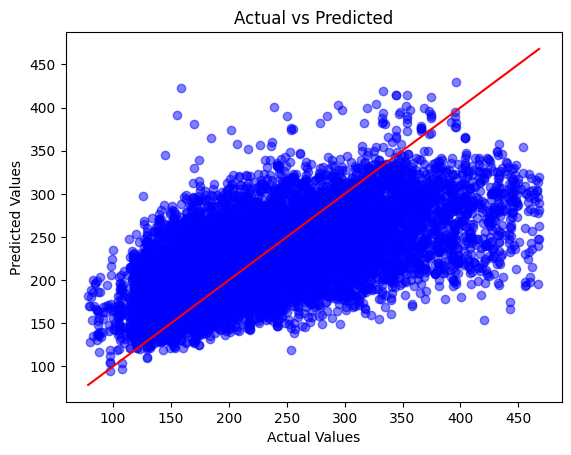

In [ ]:
evaluate_model(model1, X_test_tensor, y_test_tensor)

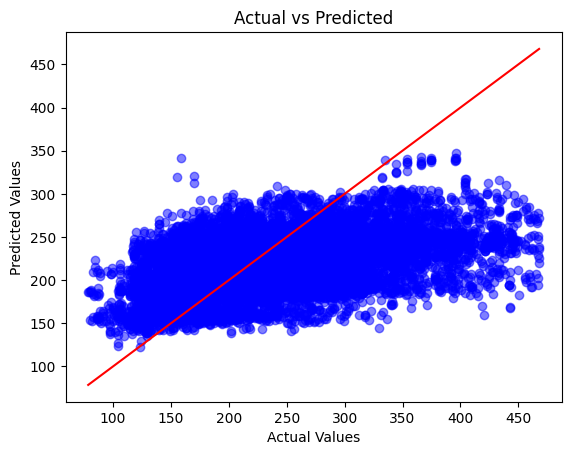

In [ ]:
evaluate_model(model2, X_test_tensor, y_test_tensor)

### Rank Feature Imprtance

In [ ]:
def display_feature_importance(model_name):
    model_copy = models[model_name]
    importance = model_copy.feature_importances_
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x=X.columns, y=importance)
    plt.title(f'Feature Importance - {model_name}')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def display_permutation_importance(model_name):
    model_copy = models[model_name]
    result = permutation_importance(model_copy, X_test_scaled, y_test, n_repeats=10, random_state=42)
    importance = result.importances_mean

    plt.figure(figsize=(10, 4))
    sns.barplot(x=X.columns, y=importance)
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.xticks(rotation=45)
    plt.show()

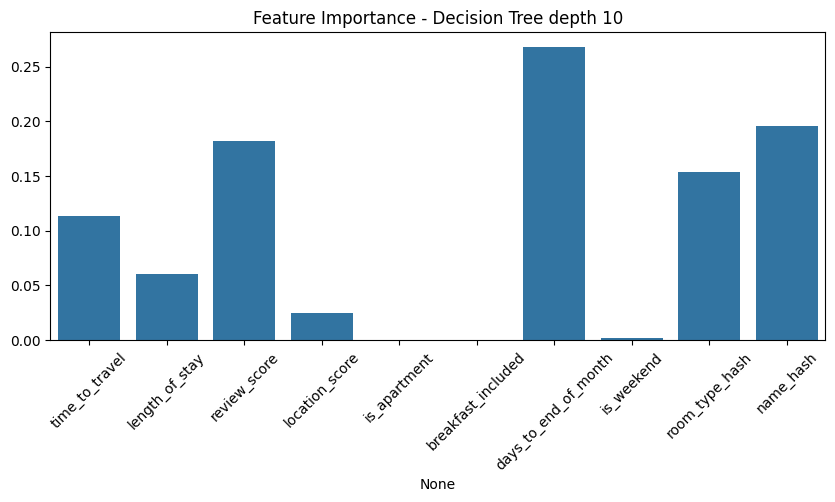

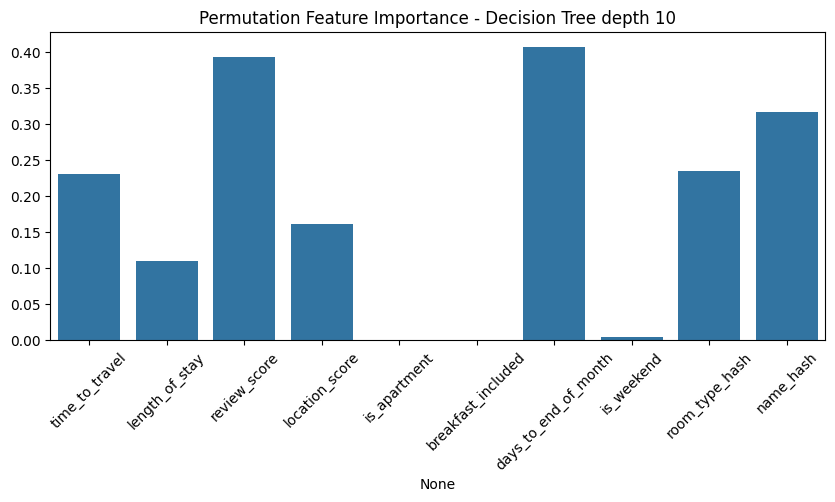

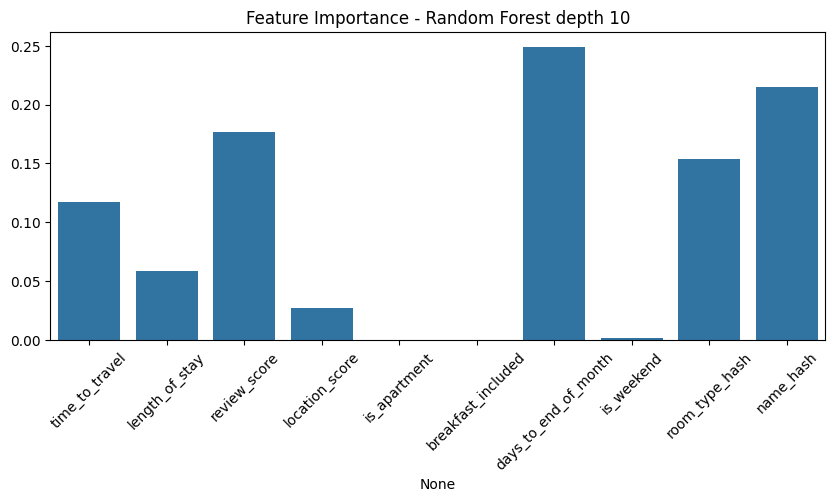

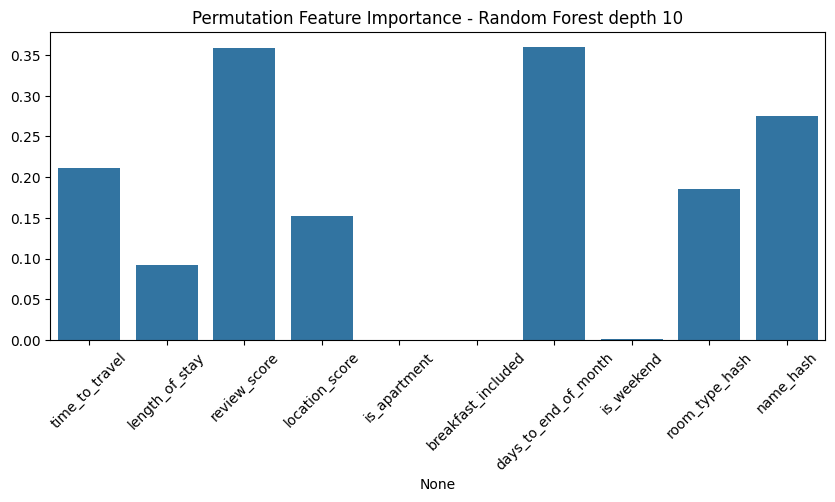

In [ ]:
models_to_visualize_feature_impotrence = ['Decision Tree depth 10','Random Forest depth 10']
display_feature_importance(models_to_visualize_feature_impotrence[0])
display_permutation_importance(models_to_visualize_feature_impotrence[0])
display_feature_importance(models_to_visualize_feature_impotrence[1])
display_permutation_importance(models_to_visualize_feature_impotrence[1])

### Residual Plot


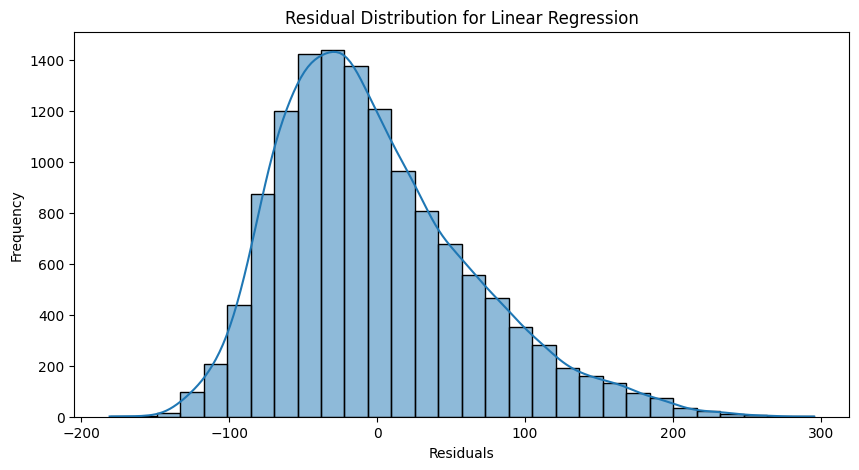

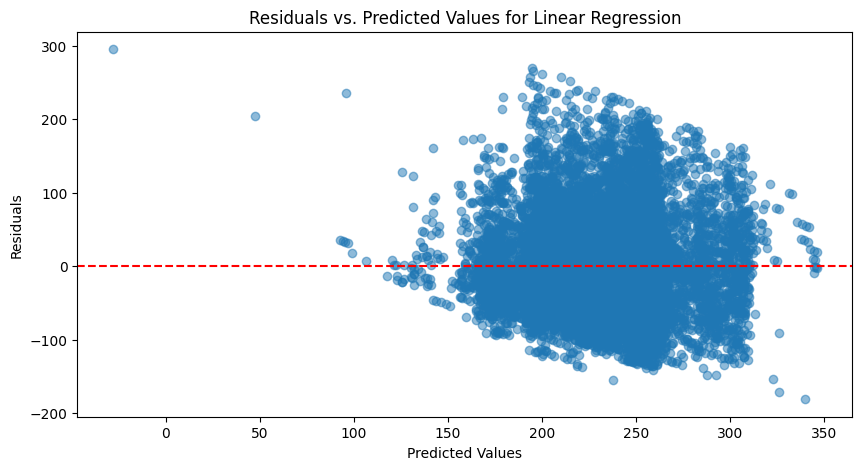

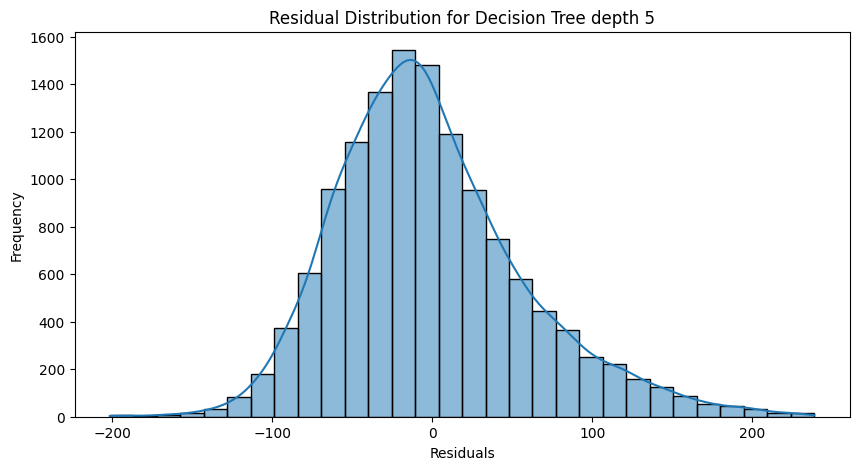

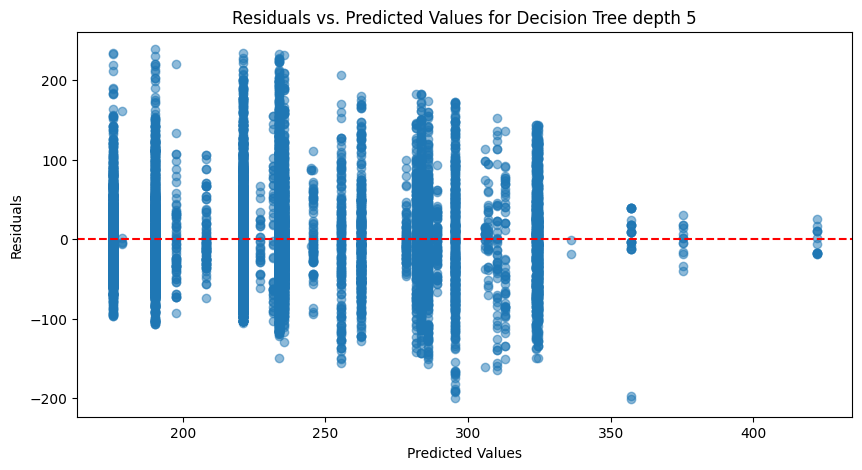

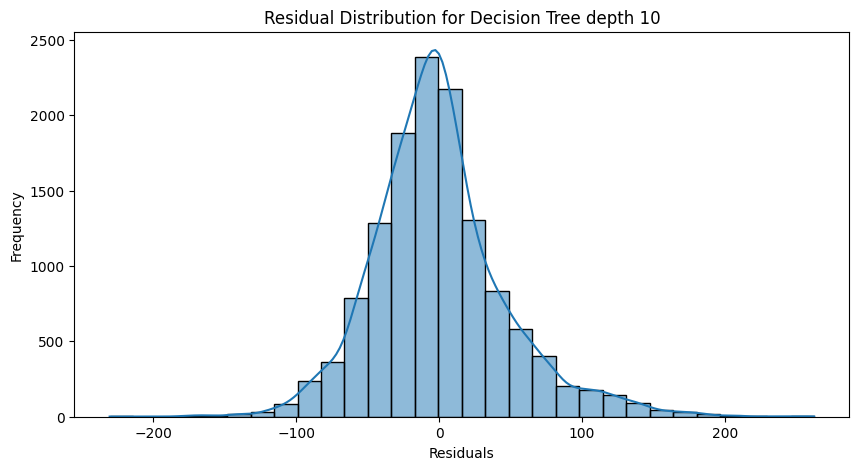

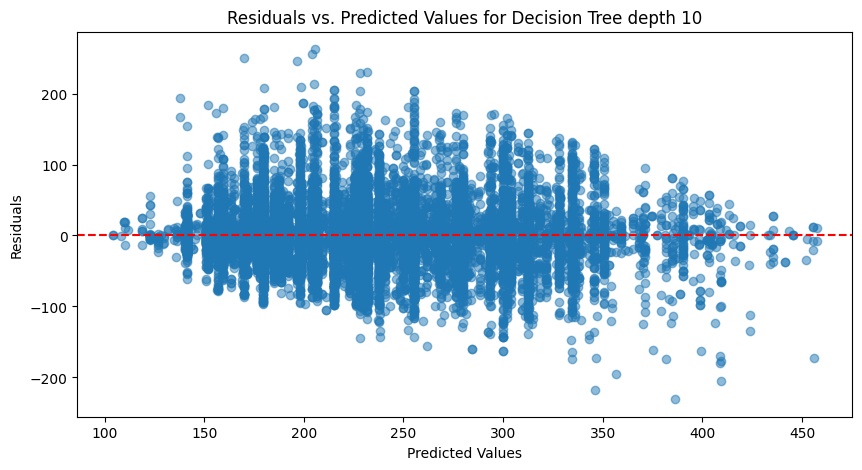

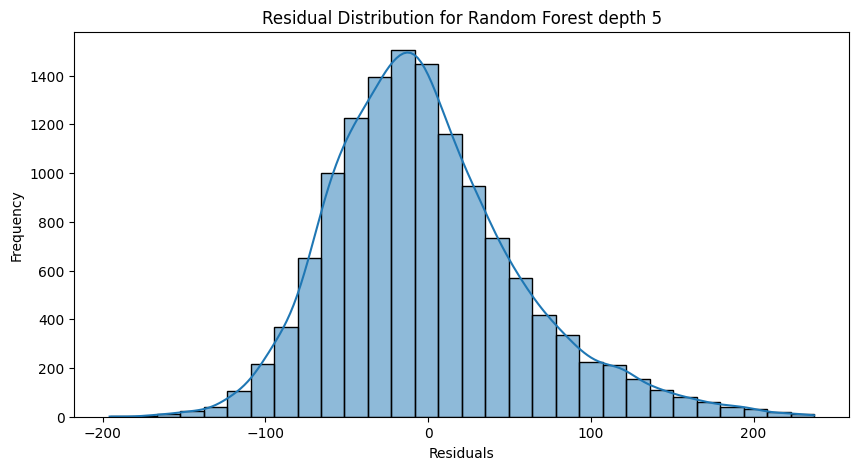

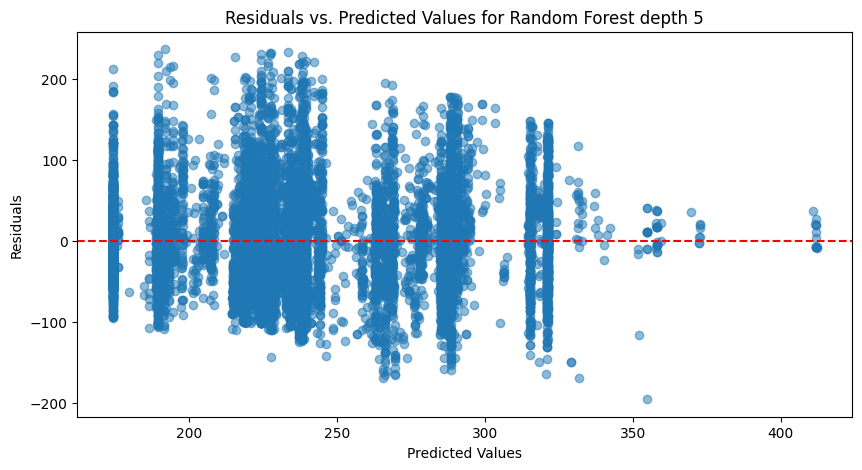

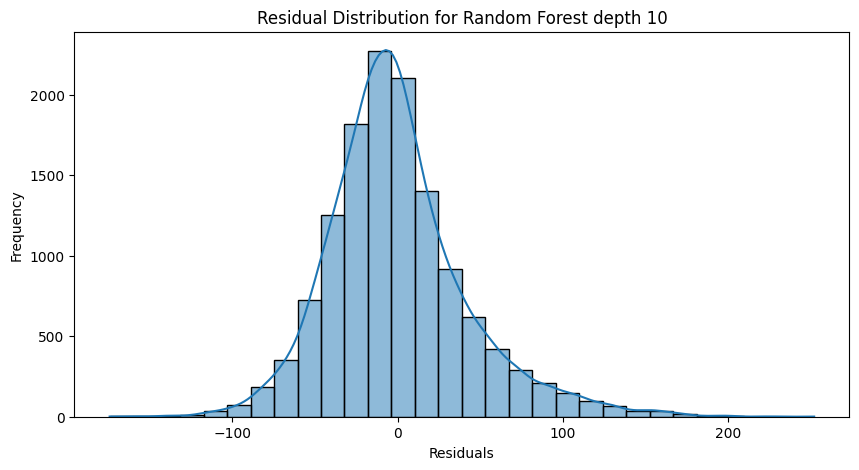

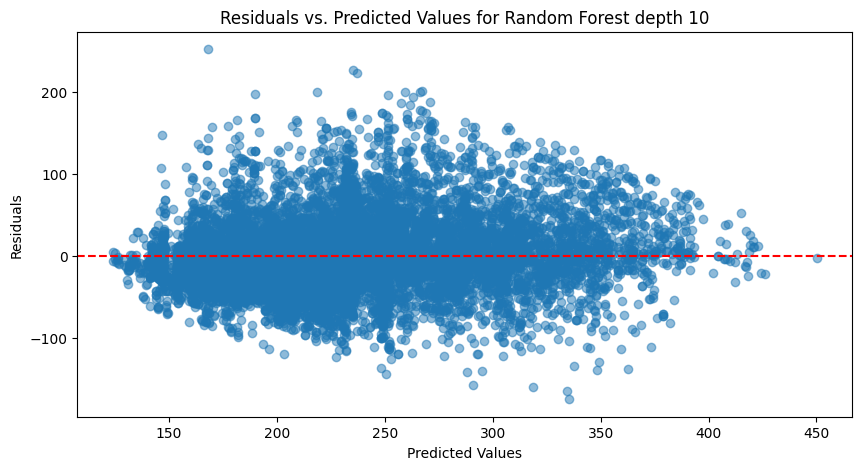

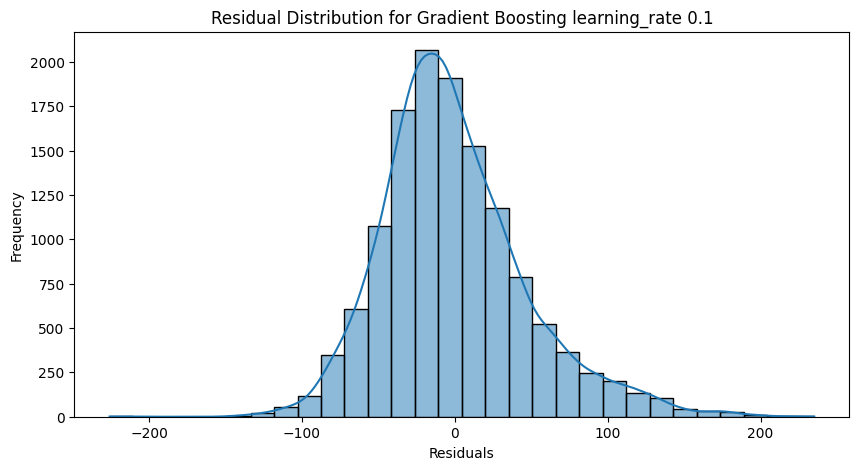

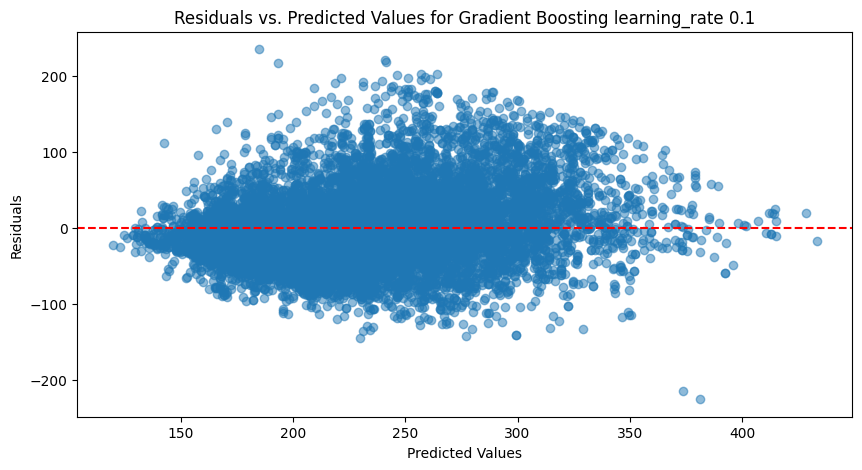

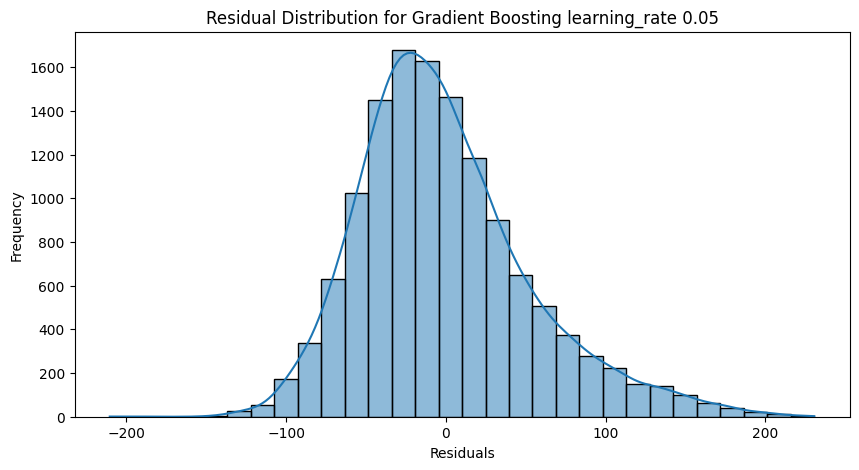

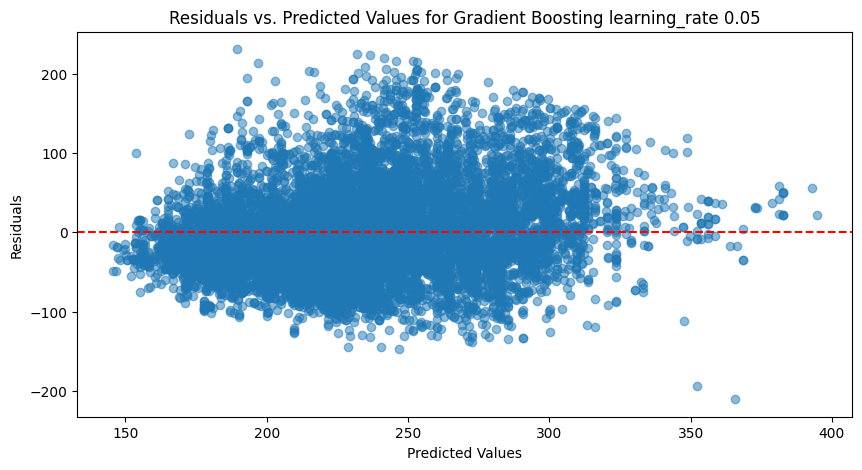

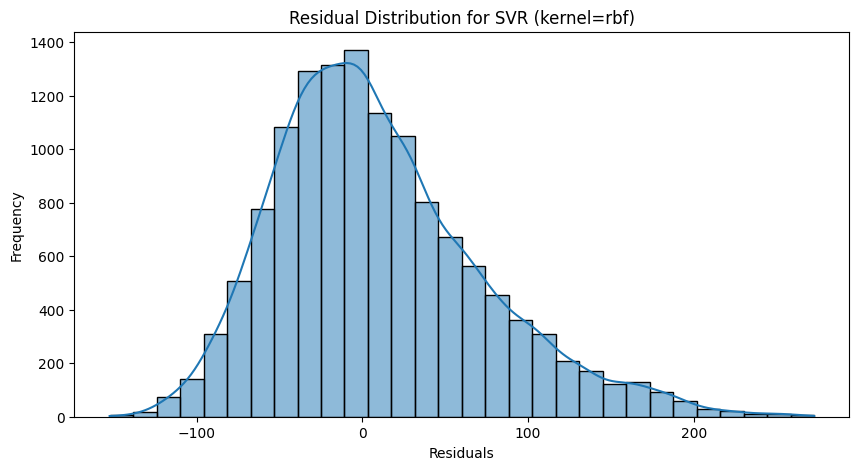

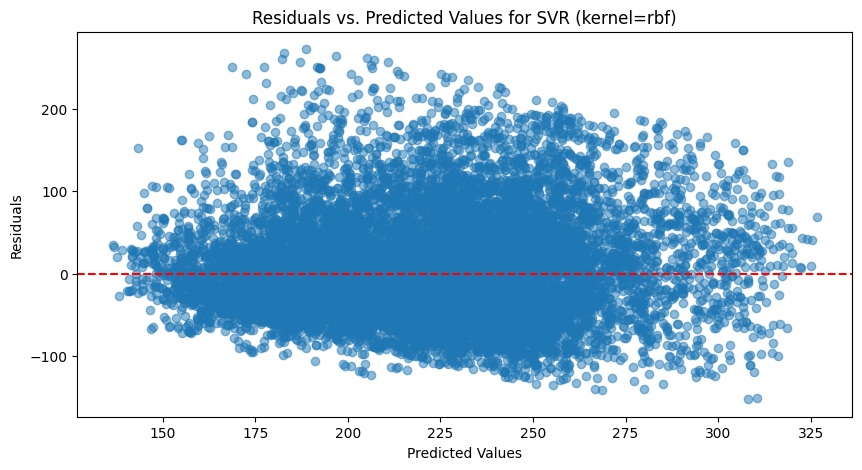

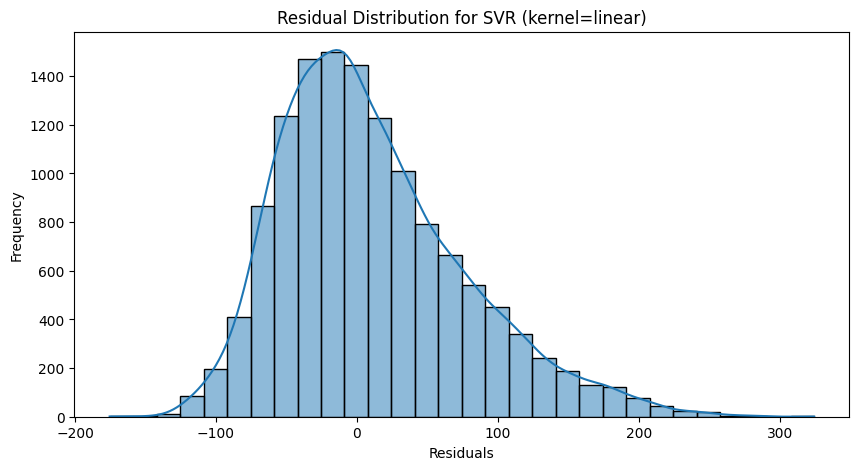

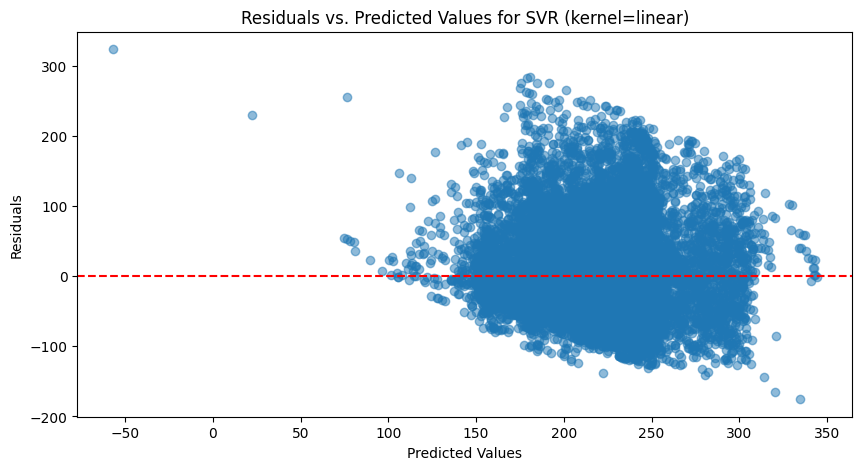

In [ ]:
for name, model_copy in models.items():
    y_pred = model_copy.predict(X_test_scaled)
    residuals = y_test - y_pred
    
    # Residual Distribution Plot
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f'Residual Distribution for {name}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Scatter Plot of Residuals vs Predicted Values
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at zero
    plt.title(f'Residuals vs. Predicted Values for {name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_17656\1404117669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, bins=30, kde=True)


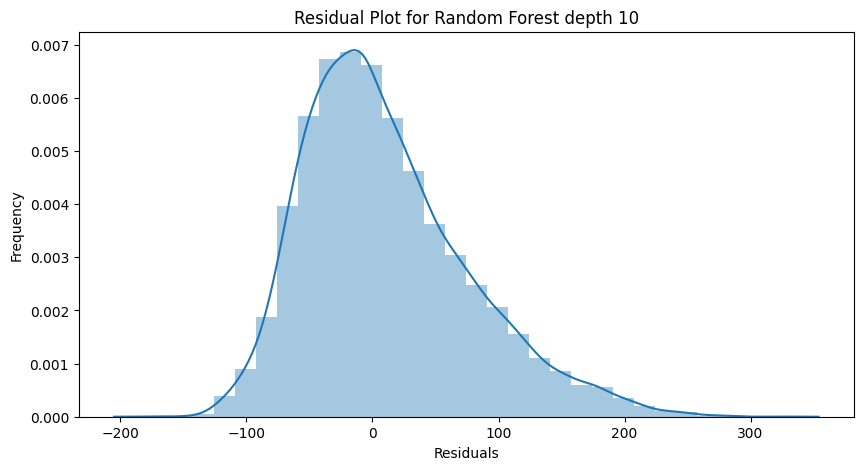

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



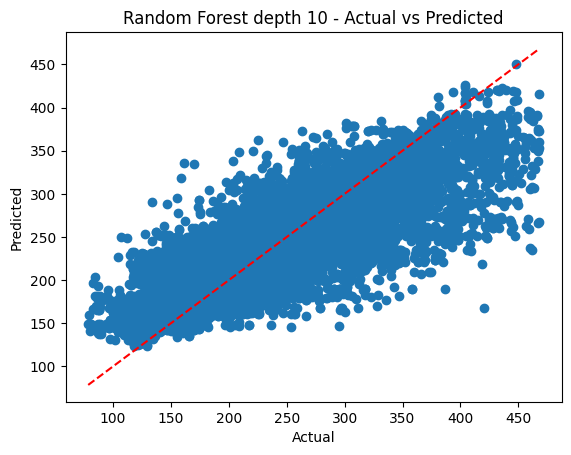

In [ ]:
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

plt.scatter(y_test, y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'{best_model_name} - Actual vs Predicted')
plt.show()

## Best Algorith TTT <= 25

In [ ]:
X_train_25, X_test_25 = X[X['time_to_travel'] <= 25], X[X['time_to_travel'] > 25]
y_train_25, y_test_25 = y[X['time_to_travel'] <= 25], y[X['time_to_travel'] > 25]

# Re-train the best model and test
best_model.fit(X_train_25, y_train_25)
y_pred_25 = best_model.predict(X_test_25)

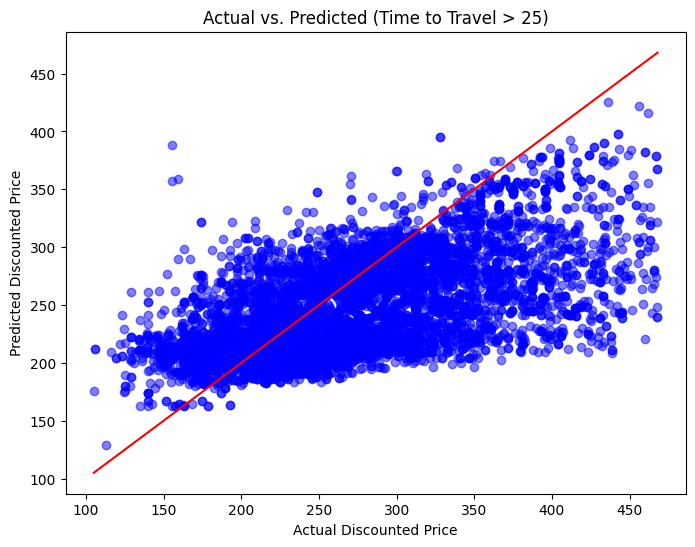

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_25, y_pred_25, alpha=0.5, color='blue')
plt.plot([y_test_25.min(), y_test_25.max()], [y_test_25.min(), y_test_25.max()], 'r')  # Identity line
plt.xlabel('Actual Discounted Price')
plt.ylabel('Predicted Discounted Price')
plt.title('Actual vs. Predicted (Time to Travel > 25)')
plt.show()

In [ ]:
results = {
          'R2': r2_score(y_test_25, y_pred_25),
          'MAE': mean_absolute_error(y_test_25, y_pred_25),
          'MSE': mean_squared_error(y_test_25, y_pred_25),
          'RMSE': np.sqrt(mean_squared_error(y_test_25, y_pred_25))
     }
results

{'R2': 0.23114265795082056,
 'MAE': 46.448413014662684,
 'MSE': 3757.7814254214913,
 'RMSE': 61.30074571668351}